<a href="https://colab.research.google.com/github/binliu0630/FASTAI_V2/blob/master/Lesson_3_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install fastai2

In [30]:
!pip install nbdev

In [0]:
%matplotlib inline
from fastai2.text.all import *
from nbdev.showdoc import *


# Prep the data

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)

In [33]:
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [34]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [17]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [18]:
df_tok, count = tokenize_df(df, text_cols='text')

In [19]:
df_tok.head()

,label,is_valid,text,text_length
0,negative,False,"[xxbos, xxmaj, un, -, bleeping, -, believable, !, xxmaj, meg, xxmaj, ryan, does, n't, even, look, her, usual, pert, lovable, self, in, this, ,, which, normally, makes, me, forgive, her, shallow, ticky, acting, schtick, ., xxmaj, hard, to, believe, she, was, the, producer, on, this, dog, ., xxmaj, plus, xxmaj, kevin, xxmaj, kline, :, what, kind, of, suicide, trip, has, his, career, been, on, ?, xxmaj, whoosh, …, xxmaj, banzai, xxrep, 3, !, xxmaj, finally, this, was, directed, by, the, guy, who, did, xxmaj, big, xxmaj, chill, ?, xxmaj, must, be, a, replay, of, xxmaj, jonestown, -, hollywood,...",108
1,positive,False,"[xxbos, xxmaj, this, is, a, extremely, well, -, made, film, ., xxmaj, the, acting, ,, script, and, camera, -, work, are, all, first, -, rate, ., xxmaj, the, music, is, good, ,, too, ,, though, it, is, mostly, early, in, the, film, ,, when, things, are, still, relatively, cheery, ., xxmaj, there, are, no, really, superstars, in, the, cast, ,, though, several, faces, will, be, familiar, ., xxmaj, the, entire, cast, does, an, excellent, job, with, the, script, ., \n\n, xxmaj, but, it, is, hard, to, watch, ,, because, there, is, no, good, end, to, a, situation, like, the, one, ...]",462
2,negative,False,"[xxbos, xxmaj, every, once, in, a, long, while, a, movie, will, come, along, that, will, be, so, awful, that, i, feel, compelled, to, warn, people, ., xxmaj, if, i, labor, all, my, days, and, i, can, save, but, one, soul, from, watching, this, movie, ,, how, great, will, be, my, joy, ., \n\n, xxmaj, where, to, begin, my, discussion, of, pain, ., xxmaj, for, starters, ,, there, was, a, musical, montage, every, five, minutes, ., xxmaj, there, was, no, character, development, ., xxmaj, every, character, was, a, stereotype, ., xxmaj, we, had, swearing, guy, ,, fat, guy, who, eats, donuts, ...]",220
3,positive,False,"[xxbos, xxmaj, name, just, says, it, all, ., i, watched, this, movie, with, my, dad, when, it, came, out, and, having, served, in, xxmaj, korea, he, had, great, admiration, for, the, man, ., xxmaj, the, disappointing, thing, about, this, film, is, that, it, only, concentrate, on, a, short, period, of, the, man, 's, life, -, interestingly, enough, the, man, 's, entire, life, would, have, made, such, an, epic, bio, -, pic, that, it, is, staggering, to, imagine, the, cost, for, production, ., \n\n, xxmaj, some, posters, elude, to, the, flawed, characteristics, about, the, man, ,, which, are, ...",184
4,negative,False,"[xxbos, xxmaj, this, movie, succeeds, at, being, one, of, the, most, unique, movies, you, 've, seen, ., xxmaj, however, this, comes, from, the, fact, that, you, ca, n't, make, heads, or, tails, of, this, mess, ., xxmaj, it, almost, seems, as, a, series, of, challenges, set, up, to, determine, whether, or, not, you, are, willing, to, walk, out, of, the, movie, and, give, up, the, money, you, just, paid, ., xxmaj, if, you, do, n't, want, to, feel, slighted, you, 'll, sit, through, this, horrible, film, and, develop, a, real, sense, of, pity, for, the, actors, involved, ,, they, 've, ...]",398


In [20]:
count.most_common(n=20)

[('xxmaj', 24930),
 ('the', 14467),
 (',', 11834),
 ('.', 11735),
 ('and', 6949),
 ('a', 6782),
 ('of', 6370),
 ('to', 5847),
 ('is', 4429),
 ('it', 4071),
 ('in', 3948),
 ('i', 3481),
 ('that', 3169),
 ('this', 3105),
 ('"', 2934),
 ("'s", 2678),
 ('-', 2188),
 ('was', 2110),
 ('\n\n', 2056),
 ('as', 1894)]

In [0]:
vocab = make_vocab(count)

In [23]:
vocab[100]

'get'

#### Factory method :TextDataLoaders

In [35]:
dbunch_lm = TextDataLoaders.from_df(df, text_col='text', label_col='label',path=path, is_lm=True)

In [13]:
dbunch_lm.vocab[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

In [14]:
dbunch_lm.train_ds[0]

(TensorText([   2,    8,   21,   16,  281,  191,   97,   29,   20,   33,  149,  232,
          883,  171,   11,    8,    9,  134,  104,   43,   13,  207,   22,    0,
           22,   98,   17,  174,   16,   12,   74,   43,  139,  116,   27,   13,
         4903,  674,   29,   11,   26,    8,    9,  124, 1113,  156,   15,   43,
         4426,   10,  165,   33,   83,   39,  186,  264,  143, 3377,   35,   64,
           17,   16,   11,   26,    8,   21,   16,   44,   14,  164,   20,   33,
          127,   35,  478,  397,    7,  267,   10,  338,   35,    7, 3256,   10,
          272,  103,   33,   83,   39,  100,   15, 2543,   11,    8,  127,   17,
           59,   33,  197,   31,   61,   39,  591,  121,  101,   51,   17,   11]),)

In [15]:
dbunch_lm.show_batch()

,text,text_
0,"xxbos i am glad to read so many negative comments about the xxmaj tritter plot . xxmaj everyone i talk to says the same thing . xxmaj they like xxmaj house 's gruff nature and his intelligence , but really dislike the vindictiveness of this xxunk plot . xxmaj it cuts into the real nature of the hospital story and makes everyone angry at police authority . xxmaj it needs to have","i am glad to read so many negative comments about the xxmaj tritter plot . xxmaj everyone i talk to says the same thing . xxmaj they like xxmaj house 's gruff nature and his intelligence , but really dislike the vindictiveness of this xxunk plot . xxmaj it cuts into the real nature of the hospital story and makes everyone angry at police authority . xxmaj it needs to have a"
1,"writing . \n\n 8 out of 10 , kids . xxbos xxmaj movie did n't have much plot and was uninteresting . xxmaj basically you spend a lot of time watching people paint . xxmaj also it 's very difficult to hear or understand the dialogue -- xxunk because of the accents , but also because words are xxunk . xxbos seriously i loved this film .. i had started to read",". \n\n 8 out of 10 , kids . xxbos xxmaj movie did n't have much plot and was uninteresting . xxmaj basically you spend a lot of time watching people paint . xxmaj also it 's very difficult to hear or understand the dialogue -- xxunk because of the accents , but also because words are xxunk . xxbos seriously i loved this film .. i had started to read the"
2,"gave it an xxunk twist in 1973 with xxup the xxup sunshine xxup boys , a xxmaj broadway hit starring xxmaj jack xxmaj xxunk and xxmaj sam xxmaj xxunk as xxmaj al xxmaj lewis and xxmaj willie xxmaj clark , the aged , semi - retired xxmaj xxunk . xxmaj here the "" apartment "" problem is reduced to a xxunk of two men who ca n't stand each other . xxmaj","it an xxunk twist in 1973 with xxup the xxup sunshine xxup boys , a xxmaj broadway hit starring xxmaj jack xxmaj xxunk and xxmaj sam xxmaj xxunk as xxmaj al xxmaj lewis and xxmaj willie xxmaj clark , the aged , semi - retired xxmaj xxunk . xxmaj here the "" apartment "" problem is reduced to a xxunk of two men who ca n't stand each other . xxmaj the"
3,"of everyone else in the film , the stupidity of the plot and the general xxunk of the film in general means it is downright impossible to get behind her character this time around . xxmaj the less said about xxmaj xxunk "" remember me from xxmaj kill xxmaj bill "" xxmaj xxunk 's performance the better ; it xxunk to say her "" turn "" from good to evil is about","everyone else in the film , the stupidity of the plot and the general xxunk of the film in general means it is downright impossible to get behind her character this time around . xxmaj the less said about xxmaj xxunk "" remember me from xxmaj kill xxmaj bill "" xxmaj xxunk 's performance the better ; it xxunk to say her "" turn "" from good to evil is about as"
4,"watching , you better skip this one . i watched this one on television , so i did n't have to xxunk down cash for it . xxmaj lucky me . \n\n xxmaj the plot develops slowly , very slowly . xxmaj although the first 30 minutes or so are quite believable , it gets more and more unbelievable towards the end . xxmaj it is highly xxunk , if a xxunk",", you better skip this one . i watched this one on television , so i did n't have to xxunk down cash for it . xxmaj lucky me . \n\n xxmaj the plot develops slowly , very slowly . xxmaj although the first 30 minutes or so are quite believable , it gets more and more unbelievable towards the end . xxmaj it is highly xxunk , if a xxunk soldier"
5,"the filmmakers to include so much good - natured humor in the film ( it 's what the xxmaj xxunk filmmakers did as well ) , the better to point up the utter absurdity of the situation and xxunk the appeal of the film for audiences both domestic and foreign . "" offside "" is obviously a cry for justice , but it is one that is made all the more effective","filmma

#### with data block API

In [12]:
imdb_lm = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True), ),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter()
                    )

dbunch_lm = imdb_lm.dataloaders(df)

In [13]:
dbunch_lm.show_batch()

,text,text_
0,"xxbos i saw this movie , just now , not when it was released and hailed as best picture of the year here in xxmaj israel . and to summarize everything right now , i will just say : this is not a good film . \n\n xxmaj this is xxmaj xxunk xxmaj xxunk 's second feature film , and i have to admit that his first and the xxup tv drama","i saw this movie , just now , not when it was released and hailed as best picture of the year here in xxmaj israel . and to summarize everything right now , i will just say : this is not a good film . \n\n xxmaj this is xxmaj xxunk xxmaj xxunk 's second feature film , and i have to admit that his first and the xxup tv drama he"
1,"at least another ten years added on to his sentence , was just too much for xxmaj jimmy ! xxmaj it was then that xxmaj jimmy decided to end it all by letting the police who by then xxunk him down do the job , that he himself did n't have the heart to do , for him ! xxbos xxmaj this movie was absolutely wonderful . xxmaj the pre - partition","least another ten years added on to his sentence , was just too much for xxmaj jimmy ! xxmaj it was then that xxmaj jimmy decided to end it all by letting the police who by then xxunk him down do the job , that he himself did n't have the heart to do , for him ! xxbos xxmaj this movie was absolutely wonderful . xxmaj the pre - partition time"
2,"sign that the xxup bbc , which once made the likes of ' the xxmaj singing xxmaj detective ' , xxunk of this of "" possibly the best drama of the year "" : for there 's little true originality on offer here , and the claim reveals a lack of ambition that is dreadfully disappointing . ' five xxmaj days ' is in fact not rubbish ; but it is xxunk","that the xxup bbc , which once made the likes of ' the xxmaj singing xxmaj detective ' , xxunk of this of "" possibly the best drama of the year "" : for there 's little true originality on offer here , and the claim reveals a lack of ambition that is dreadfully disappointing . ' five xxmaj days ' is in fact not rubbish ; but it is xxunk ,"
3,"killed ( his girlfriend in "" xxunk "" ) by them . xxmaj that 's all a part of the super - hero story , including a character with ( realistic but still impressive : he almost invincible ) super powers . \n\n xxmaj and the interesting point is that the evil he fights all across the world ( there 's no xxunk in the xxmaj bourne 's movies , characters are","( his girlfriend in "" xxunk "" ) by them . xxmaj that 's all a part of the super - hero story , including a character with ( realistic but still impressive : he almost invincible ) super powers . \n\n xxmaj and the interesting point is that the evil he fights all across the world ( there 's no xxunk in the xxmaj bourne 's movies , characters are going"
4,". \n\n xxmaj ugh . xxup bad job , xxmaj evening the film . xxmaj you were n't entertaining and you were n't even thought - provoking . i sure hope the book was better , so it did n't waste even more of people 's time . 3 / 10 xxbos xxmaj cute film about three lively sisters from xxmaj switzerland ( often seen running about in xxunk outfits ) who","\n\n xxmaj ugh . xxup bad job , xxmaj evening the film . xxmaj you were n't entertaining and you were n't even thought - provoking . i sure hope the book was better , so it did n't waste even more of people 's time . 3 / 10 xxbos xxmaj cute film about three lively sisters from xxmaj switzerland ( often seen running about in xxunk outfits ) who want"
5,"badly written that you really do n't care one bit about them . xxmaj the movie has no plot , no direction and no purpose . xxmaj the single redeeming quality of the movie was to treat it as a glimpse into the messed up lives of a few losers - and that 's hardly xxunk even as an afternoon waste . xxbos xxmaj standard rise to fame tale that has a","written that you really do n't care one bit about them . xxmaj the movie has no plot , no direction and no purpose . xxmaj the single redeeming quality of the mov

# Language Model

In [0]:
bs = 64

In [45]:
path = untar_data(URLs.IMDB)
path.ls()

(#8) [Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/models'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_lm')]

In [46]:
(path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/pos'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/neg')]

In [8]:
imdb_lm = DataBlock(blocks=(TextBlock.from_folder(path, is_lm=True),),
                    get_items=partial(get_text_files, folders=['train', 'test', 'unsup']),
                    splitter=RandomSplitter(0.1)
                    )



In [0]:
dbunch_lm  = imdb_lm.dataloaders(path, path=path, bs=bs, seq_len=80)

In [10]:
len(dbunch_lm.vocab)


60008

In [0]:
learn = language_model_learner(dbunch_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

(0.014454397559165954, 3.019951861915615e-07)

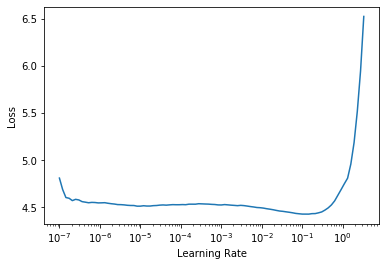

In [37]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.850579,4.002139,0.273426,54.715065,00:16


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 2e-3, moms=(0.8, 0.7, 0.8))

In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned')

In [0]:

TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [41]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because of its French style . It is something that i can still think of in my own mind . It really stands for the burning and the people being in the sight of me . It
i liked this movie because it was born to be a fun film . This was " excellent " . While George Burns was not a great film , it was a great start . The movie was not a


In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [0]:
imdb_clas = DataBlock(blocks=(TextBlock.from_folder(path, vocab=dbunch_lm.vocab),CategoryBlock),
                      get_x=read_tokenized_file,
                      get_y = parent_label,
                      get_items=partial(get_text_files, folders=['train', 'test']),
                      splitter=GrandparentSplitter(valid_name='test'))

dbunch_clas = imdb_clas.dataloaders(path, path=path, bs=bs, seq_len=80)

In [48]:
dbunch_clas.show_batch()

,text,category
0,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk and xxunk xxunk vs xxunk xxunk and xxunk xxunk xxunk xxunk and xxunk xxunk started things off with a xxunk xxunk xxunk xxunk against xxunk xxunk and xxunk xxunk xxunk to the rules of the xxunk both xxunk have to go through tables in order to get the xxunk xxunk and xxunk xxunk up early on by taking turns xxunk first xxunk and then xxunk xxunk xxunk xxunk xxunk by xxunk to xxunk took the wind out of the xxunk xxunk xxunk tried to help his xxunk but the xxunk xxunk him while xxunk and xxunk xxunk up on him in the xxunk xxunk xxunk xxunk away on xxunk xxunk set up a table xxunk xxunk xxunk into the ring and xxunk over the top xxunk onto xxunk on the xxunk xxunk xxunk and taking care of xxunk xxunk xxunk a table,pos
1,xxunk directed by xxunk xxunk presents a fictional love story on the historical setting of the xxunk xxunk plot is xxunk xxunk or not for those who love plots that twist and turn and keep you in xxunk xxunk end of the movie can be figured out within minutes of the start of the xxunk but the love story is an interesting xxunk xxunk xxunk xxunk is wonderful as xxunk an xxunk young lady xxunk by xxunk xxunk xxunk xxunk on the voyage xxunk meets xxunk xxunk xxunk a lower class artist on his way to xxunk after winning his ticket xxunk xxunk in a xxunk xxunk xxunk he wants xxunk he goes and gets it unlike the upper class who are so concerned with their social xxunk xxunk two fall in love and the audience sees the xxunk of the xxunk primarily through their xxunk xxunk xxunk movie begins,pos
2,xxunk movie was recently released on xxunk in the xxunk and xxunk finally got the chance to see this xxunk xxunk xxunk even came with original theatrical previews of other xxunk horror classics like xxunk and xxunk xxunk xxunk xxunk the previews were the best thing about this xxunk xxunk xxunk xxunk in a bizarre way is actually linked to the infamous xxunk xxunk xxunk franchise which began in xxunk xxunk compared to xxunk xxunk xxunk consists of a xxunk plot and a handful of extremely bad actors that keeps this xxunk trash barely xxunk xxunk gore is nearly xxunk xxunk one is frightened of people running around with green xxunk on their xxunk and the xxunk dubbing is a notch below xxunk xxunk xxunk plot this time around involves some sort of xxunk military operation with a bunch of inept scientists xxunk an idiotic male and his stupid female,neg
3,xxunk film maker xxunk xxunk xxunk xxunk xxunk xxunk aka xxunk xxunk is among the most controversial and brave films ever made and a very excellent one xxunk xxunk film tells everything xxunk generally been hidden and xxunk about our nature and our sexual nature in particular with the xxunk and silence of its xxunk xxunk images may look xxunk xxunk xxunk or xxunk but they are all in relation with the xxunk xxunk xxunk desire and death are very strong and primary things and xxunk all the flesh that has a human soul inside xxunk xxunk interest and xxunk us so powerfully xxunk by our xxunk that they are considered xxunk xxunk and something too wild to be xxunk xxunk xxunk xxunk sophisticated young woman xxunk with her mother to a xxunk countryside to meet her xxunk husband whom with she has had a letter affair of some xxunk,pos
4,xxunk xxunk xxunk xxunk xxunk here on in the whole movie xxunk in on xxunk xxunk we meet a xxunk program with the indication xxunk xxunk get ghosts and vampires and xxunk and the xxunk xxunk get a guy with a retarded accent talking endless xxunk two xxunk that serve no real purpose and have no character xxunk and a bunch of xxunk xxunk told me xxunk vampires xxunk out of xxunk xxunk but xxunk so xxunk xxunk xxunk xxunk xxunk xxunk funny xxunk guy with a ridiculous name suffers the same problem as the xxunk only for far longer and far far xxunk xxunk has a simple point about cause and xxunk makes xxunk then continues to make it and make it until it becomes convoluted and xxunk xxunk final line before walking

In [51]:

learn = text_classifier_learner(dbunch_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc')

(0.03019951581954956, 2.5118865210060903e-07)

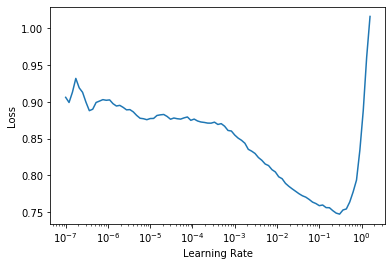

In [52]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.573770,0.439789,0.795840,03:19


In [29]:
learn.save('first')
learn.load('first')

In [55]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.589392,0.437593,0.798400,03:19


In [56]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.584401,0.432725,0.800320,03:20


In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.494750,0.371996,0.835960,01:38
1,0.503213,0.372557,0.834560,01:39


In [35]:
learn.predict('I really loved the movie. It was awesome!')

ValueError: ignored